# Project Phase 2
### Samantha Rubin, Hanwen Lin, Liz Espinoza, and Hanna Kang

## Research questions:
- Is there a relationship between wealth inequality (Gini index) and high rates of positive COVID cases in relation to the total population and/or COVID deaths across different countries?
- Is there a relationship between GDP per capita and high rates of positive COVID cases in relation to the total population and/or COVID deaths across different countries?
- Is there a relationship between the ratio of positive COVID results to COVID deaths and a country’s GDP and/or Gini index?


-----
## Data collection and cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Data is imported below.

In [2]:
raw_covid = pd.read_csv("jrc-covid-19-world-latest.csv")
gini_data = pd.read_csv("gini_data2.csv")
gdp_data = pd.read_csv("gdp_data.csv")
pop_data = pd.read_csv("API_SP.POP.TOTL_DS2_en_csv_v2_2106202.csv")
pop_den = pd.read_csv("pop_density.csv")
unemploy_rates = pd.read_csv("unemployment_rates.csv")
#avg_households = pd.read_csv("avg_house.csv")

For gdp_data and gini_data, what should be the column labels are actually stored in the third row, and the data starts on the fourth row.  We fix this below.

In [3]:
gdp_data.columns = gdp_data.loc[3]
gdp_data = gdp_data.drop(index = [0,1,2,3])

Removing unnecessary columns and renaming them:

In [4]:
#making covid data column names lowercase
new_colnames = [i.lower() for i in raw_covid.columns]
covid_cases = raw_covid.copy()
for i in covid_cases.columns:
    covid_cases.columns = new_colnames
# #dropping unnecessary columns:
# covid_cases = covid_cases[['date', 'iso3', 'continent', 'countryname'
#                            , 'cumulativepositive', 'cumulativedeceased', 'cumulativerecovered'
#                            , 'currentlypositive', 'hospitalized', 'intensivecare']]
# #renaming columns
# covid_cases.rename(columns = {'iso3':'country_code','countryname':'country_name'
#                               , 'cumulativepositive':'cumulative_pos', 'cumulativedeceased':'cumulative_dec'
#                               , 'cumulativerecovered':'cumulative_rec', 'currentlypositive':'curr_pos'
#                               , 'intensivecare':'intensive_care'}, inplace = True)


#dropping unnecessary columns:
covid_cases = covid_cases[['date', 'iso3', 'continent', 'countryname'
                           , 'cumulativepositive', 'cumulativedeceased'
                           , 'currentlypositive']]
#renaming columns
covid_cases.rename(columns = {'iso3':'country_code','countryname':'country_name'
                              , 'cumulativepositive':'cumulative_pos', 'cumulativedeceased':'cumulative_dec'
                              , 'currentlypositive':'curr_pos'}, inplace = True)



#clean gdp data, drop unecessary columns and rename them
new_colnames = []
gdp = gdp_data.copy()
gdp.rename(columns = {"Country Name":"country_name","Country Code":"country_code",2019:"gdp_per_cap"}, inplace = True)
gdp = gdp[["country_name","country_code","gdp_per_cap"]]

#drop NaNs in gdp
gdp = gdp.dropna(axis = 0,subset=["gdp_per_cap"])

#clean gini column names
gini_data.rename(columns = {"Country Code":"country_code",
                          "Country":"country","Value":"gini_index",'Year':"gini_year"},inplace = True)

#clean population data
pop_data.rename(columns = {"Country Code":"country_code","Country Name":"country_name","2019":"population"}
                ,inplace = True)
pop_data = pop_data[["country_code",'country_name','population']]

#clean population density 
pop_den.rename(columns = {"Country Code":"country_code","Country Name":"country_name","2018":"density"}
               ,inplace = True)
pop_den = pop_den[['country_code','country_name','density']]

#clean unemployment rates 
unemploy_rates.rename(columns = {"Country Code":"country_code","Country Name":"country_name","2019":"rates"}
                      ,inplace = True)
unemploy_rates = unemploy_rates[['country_code','country_name','rates']]

#clean average households 
# avg_households.rename(columns = {"Country Code":"country_code","Country Name":"country_name","2019":"size"}
#                       ,inplace = True)
# avg_households = avg_households[['country_code','country_name','size']]



Matching countries via country codes, only keeping the countries that have GDP, gini, and covid data. We printed the length to see how many countries were dropped

In [5]:
#adding gdp 
covid_gdp = pd.merge(left = covid_cases, right = gdp, left_on = "country_code",right_on = "country_code")
print(len(covid_gdp))

#adding gini
covid_gdp_gini = pd.merge(left = covid_gdp, right = gini_data, left_on = "country_code",right_on = "country_code")
print(len(covid_gdp_gini))

#adding population 
covid_gdp_gini = pd.merge(left = covid_gdp_gini, right = pop_data, left_on = "country_code",right_on = "country_code")
print(len(covid_gdp_gini))

#adding population density
covid_gdp_gini = pd.merge(left = covid_gdp_gini, right = pop_den, left_on = "country_code",right_on = "country_code")
print(len(covid_gdp_gini))

#adding unemployment rates
covid_data = pd.merge(left = covid_gdp_gini, right = unemploy_rates, left_on = "country_code",right_on = "country_code")
print(len(covid_data))

#adding average households
# covid_data = pd.merge(left = covid_gdp_gini, right = avg_households, left_on = "country_code",right_on = "country_code")
# print(len(covid_data))



#removing duplicate columns
covid_data = covid_data.drop(columns = ["country",'country_name_y',"country_name"])
covid_data.rename(columns = {"country_name_x":"country_name"},inplace = True)

166
140
140
136
136


In [6]:
covid_data.rename(columns = {'density':'pop_density', 'rates': 'unemploy_rates'}, inplace = True)

covid_data.drop_duplicates(subset = 'country_name', keep = 'first', inplace = True)

covid_data.head()

,date,country_code,continent,country_name,cumulative_pos,cumulative_dec,curr_pos,gdp_per_cap,gini_index,gini_year,country_name,population,pop_density,unemploy_rates
0,2021-03-13,ALB,EU,Albania,116821,2030,34970.0,5353.244856,29.0,2012,Albania,2854191.0,104.6122628,11.47000027
1,2021-02-15,DZA,AF,Algeria,110711,2939,107772.0,3973.964072,27.6,2011,Algeria,43053054.0,17.73006763,11.81000042
2,2021-02-15,AGO,AF,Angola,20366,492,19874.0,2790.726615,42.7,2008,Angola,31825295.0,24.71305206,6.929999828
3,2021-02-15,ARG,SA,Argentina,2029008,50327,1978681.0,9912.281809,41.2,2017,Argentina,44938712.0,16.2585101,9.840000153
4,2021-02-15,AUS,OC,Australia,28900,909,27991.0,55060.326100,35.8,2014,Australia,25364307.0,3.24787091,5.159999847


## Data Description

 There is not a lot of information on the relationship between wealth inequality (quantified by the Gini index) or GDP per capita, and high rates of positive COVID-19 cases and/or COVID-19 deaths across different countries. This is especially the case as COVID-19 is still ongoing to the present day. To address this, we have chosen to analyze three datasets. The first dataset contains data from the Joint Research Centre (JRC), which was made to further understand COVID-19, to predict any potential impacts, and to support future planning. Included columns are cumulative positive and cumulative recovered COVID-19 cases, as well as cumulative deceased and the number of hospitalized and intensive care patients. Rows in this dataset include the names of countries and their respective country codes. 
     The other two datasets are simpler, only having data of country names and codes, and either the respective Gini indexes or the GDP per capita. These were created to look at all of the Gini indexes and GDP per capita of countries. We will only be analyzing countries that have both of these values, and are also on the COVID-19 dataset. 
     Analysis on these datasets will help to find potential relationships between COVID-19 cases and the Gini indexes and GDP per capita of countries. Through this, we hope to determine how the wealth of a country changes how it has been affected by COVID-19.

Here is a shared Google Drive folder with all four of our raw datasets:
https://drive.google.com/drive/folders/1OAunMYE2SKDuoehcmpewYIPKlBWcg3fU?usp=sharing 
The data was sourced from the following sites:
Covid data source: https://github.com/ec-jrc/COVID-19/blob/master/data-of-world/jrc-covid-19-world-latest.csv  
This dataset contains COVID-19 data of each country in the world, with columns such as cumulative positive cases and hospitalizations.  

Gini index data source: https://data.worldbank.org/indicator/SI.POV.GINI/?end=2018&start=2015 
This dataset contains the Gini index for each country for which it is available.

GDP per capita data source: https://data.worldbank.org/indicator/NY.GDP.PCAP.CD 
note: for this data set, we had to remove the final column (2020), which had no data in it to avoid errors.  This dataset contains the gross domestic product per capita of each country.

Population data source: https://data.worldbank.org/indicator/SP.POP.TOTL 

## Data Limitations

- Not all countries have reported a Gini index or GDP per capita value, so this is not representative of the whole world.  
- Some countries’ Gini indexes are up-to-date, while some countries’ are not.
- Some countries with low GDP per capita and/or low Gini indices may also have low life expectancies due to many social, political and environmental factors. A country’s high Covid death rate may thus also be influenced by its low life expectancy.
- Some countries might have less accurate COVID data than others.
- Because the original dataset is updated daily, the dataset we have saved will not have all current COVID data, and may not be accurate to the present day. 


------
## Exploratory Data Analysis

Scatterplot of cumulative positive cases vs population

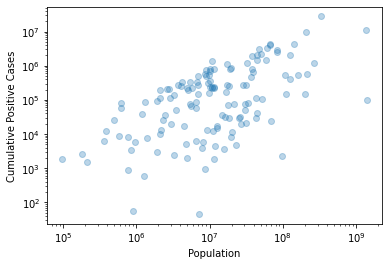

In [7]:
plt.axes(xscale = "log", yscale = "log")
plt.scatter(x = covid_data["population"],y = covid_data["cumulative_pos"], alpha = 0.3)
plt.xlabel("Population")
plt.ylabel("Cumulative Positive Cases")
plt.show()

Above we can see that population and cumulative positive cases are positively correlated.  To account for this, we make 2 new columns, cumulative positive COVID cases by country normalized by the population of each country, and cumulative COVID deaths normalized by population.

In [8]:
cpos_norm = []
for i in range(len(covid_data.cumulative_pos)):
    cpos_norm.append(covid_data.cumulative_pos[i]/covid_data.population[i])
covid_data['cpos_norm'] = cpos_norm

cdec_norm = []
for i in range(len(covid_data.cumulative_dec)):
    cdec_norm.append(covid_data.cumulative_dec[i]/covid_data.population[i])
covid_data['cdec_norm'] = cdec_norm

Histogram of GDP per capita:

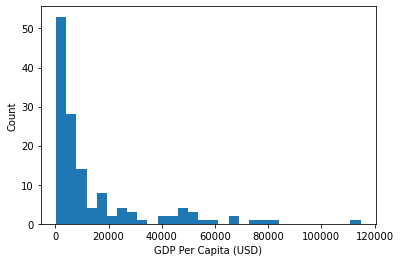

In [9]:
plt.hist(covid_data["gdp_per_cap"], bins = 30)
plt.xlabel("GDP Per Capita (USD)")
plt.ylabel("Count")
plt.show()

This data is very right skewed. 

Histogram of Gini index:

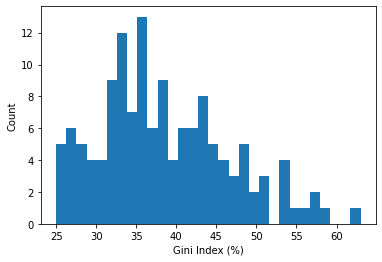

In [10]:
plt.hist(covid_data["gini_index"], bins = 30)
plt.xlabel("Gini Index (%)")
plt.ylabel("Count")
plt.show()

This data is close to normally distributed, with a slight right skew. 

Histogram of cumulative positive cases per capita

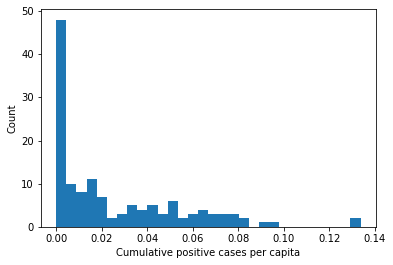

In [11]:
plt.hist(covid_data["cpos_norm"], bins = 30)
plt.xlabel("Cumulative positive cases per capita")
plt.ylabel("Count")
plt.show()

Histogram of cumulative deaths per capita

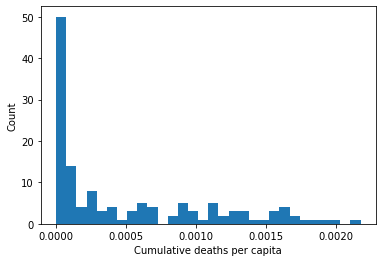

In [12]:
plt.hist(covid_data["cdec_norm"], bins = 30)
plt.xlabel("Cumulative deaths per capita")
plt.ylabel("Count")
plt.show()

Both cumulative positive cases and deaths per capita are very right skewed, especially deaths.  

#### Scatterplot of normalized cumulative positive cases vs GDP per capita

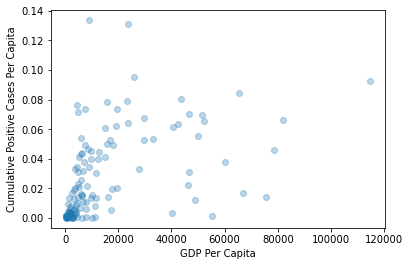

In [13]:
plt.scatter(x = covid_data["gdp_per_cap"],y = covid_data["cpos_norm"], alpha = 0.3)
plt.xlabel("GDP Per Capita")
plt.ylabel("Cumulative Positive Cases Per Capita")
plt.show()

To see a clearer trend we might have to plot this on a log graph or consider removing outliers.

#### Scatterplot of normalized cumulative deaths vs GDP per capita:

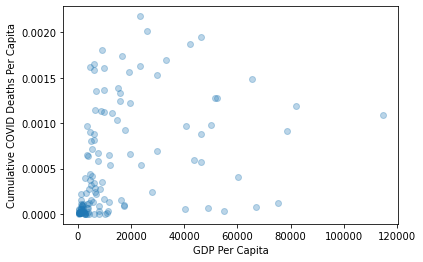

In [14]:
plt.scatter(x = covid_data["gdp_per_cap"],y = covid_data["cdec_norm"], alpha = 0.3)
plt.xlabel("GDP Per Capita")
plt.ylabel("Cumulative COVID Deaths Per Capita")
plt.show()

There is a similar issue with this graph.  Part of the issue is that GDP isn't normally distributed.

#### Scatterplot of normalized cumulative positive cases vs gini index:

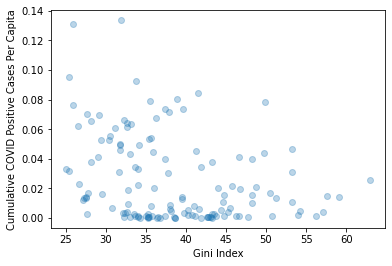

In [15]:
plt.scatter(x = covid_data["gini_index"],y = covid_data["cpos_norm"], alpha = 0.3)
plt.xlabel("Gini Index")
plt.ylabel("Cumulative COVID Positive Cases Per Capita")
plt.show()

Because this data is not normally distributed, it is difficult to discern trends from the scatterplot.  We may have to try other methods to find trends in gini data. 

#### Scatterplot of normalized cumulative deaths cases vs gini index:

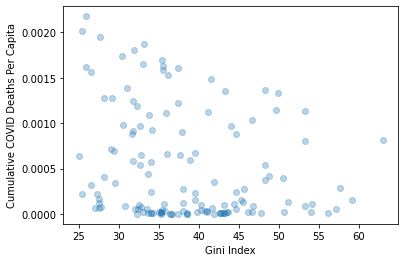

In [16]:
plt.scatter(x = covid_data["gini_index"],y = covid_data["cdec_norm"], alpha = 0.3)
plt.xlabel("Gini Index")
plt.ylabel("Cumulative COVID Deaths Per Capita")
plt.show()

## Questions for reviewers

- Should we be concerned about other possible external factors that may also influence a country’s positive COVID rate and death rate? For example, the density and the distribution of the population? Or the effect of government COVID policies?
- We are interested in two potential factors (GDP per capita and Gini Index) that may affect a country’s COVID data. What kind of test should we use to determine whether each or both factor(s) may have a correlation with positive and death rates? Maybe a Factorial (Two-Factor) Anova Test? Should we also test both the main effects and the interaction effects?
- What type(s) of graph do you recommend us to use for our particular research questions?
- Does the scope of our project seem too small or too large?


## ANOVA

### We will perform a two-way ANOVA (“analysis of variance”) to determine how the GDP per capita and gini index of a country affect cumulative COVID cases per capita, and if there are any interaction effects between GDP per capita and gini index.


Below we group countries into thirds based on GDP per capita, make the three groups into new columns and append them to the dataframe, and create indicator variables to indicate whether a country has a low, medium, or high GDP. Please swipe all the way to the right to see the three new columns (third-to-last column: low GDP; second-to-last: medium GDP; last: high GDP).  


In [17]:
x=pd.qcut(covid_data['gdp_per_cap'], q=3)
covid_data[['gdp_thirds']]=x
categories=pd.get_dummies(covid_data['gdp_thirds'])
covid_data=pd.concat([covid_data, categories], axis=1)
covid_data.head()

,date,country_code,continent,country_name,cumulative_pos,cumulative_dec,curr_pos,gdp_per_cap,gini_index,gini_year,country_name,population,pop_density,unemploy_rates,cpos_norm,cdec_norm,gdp_thirds,"(261.24600000000004, 3316.176]","(3316.176, 10261.679]","(10261.679, 114704.594]"
0,2021-03-13,ALB,EU,Albania,116821,2030,34970.0,5353.244856,29.0,2012,Albania,2854191.0,104.6122628,11.47000027,0.040930,0.000711,"(3316.176, 10261.679]",0,1,0
1,2021-02-15,DZA,AF,Algeria,110711,2939,107772.0,3973.964072,27.6,2011,Algeria,43053054.0,17.73006763,11.81000042,0.002572,0.000068,"(3316.176, 10261.679]",0,1,0
2,2021-02-15,AGO,AF,Angola,20366,492,19874.0,2790.726615,42.7,2008,Angola,31825295.0,24.71305206,6.929999828,0.000640,0.000015,"(261.24600000000004, 3316.176]",1,0,0
3,2021-02-15,ARG,SA,Argentina,2029008,50327,1978681.0,9912.281809,41.2,2017,Argentina,44938712.0,16.2585101,9.840000153,0.045151,0.001120,"(3316.176, 10261.679]",0,1,0
4,2021-02-15,AUS,OC,Australia,28900,909,27991.0,55060.326100,35.8,2014,Australia,25364307.0,3.24787091,5.159999847,0.001139,0.000036,"(10261.679, 114704.594]",0,0,1


Renaming columns to make them easier to work with:

In [26]:
covid_data.rename(columns = {pd.Interval(261.24600000000004, 3316.176, closed='right'):"low_gdp_pc", pd.Interval(3316.176, 10261.679, closed='right'):"med_gdp_pc", pd.Interval(10261.679, 114704.594, closed='right'):"high_gdp_pc" }, inplace = True)

covid_data.head()

,date,country_code,continent,country_name,cumulative_pos,cumulative_dec,curr_pos,gdp_per_cap,gini_index,gini_year,country_name,population,pop_density,unemploy_rates,cpos_norm,cdec_norm,gdp_thirds,low_gdp_pc,med_gdp_pc,high_gdp_pc
0,2021-03-13,ALB,EU,Albania,116821,2030,34970.0,5353.244856,29.0,2012,Albania,2854191.0,104.6122628,11.47000027,0.040930,0.000711,"(3316.176, 10261.679]",0,1,0
1,2021-02-15,DZA,AF,Algeria,110711,2939,107772.0,3973.964072,27.6,2011,Algeria,43053054.0,17.73006763,11.81000042,0.002572,0.000068,"(3316.176, 10261.679]",0,1,0
2,2021-02-15,AGO,AF,Angola,20366,492,19874.0,2790.726615,42.7,2008,Angola,31825295.0,24.71305206,6.929999828,0.000640,0.000015,"(261.24600000000004, 3316.176]",1,0,0
3,2021-02-15,ARG,SA,Argentina,2029008,50327,1978681.0,9912.281809,41.2,2017,Argentina,44938712.0,16.2585101,9.840000153,0.045151,0.001120,"(3316.176, 10261.679]",0,1,0
4,2021-02-15,AUS,OC,Australia,28900,909,27991.0,55060.326100,35.8,2014,Australia,25364307.0,3.24787091,5.159999847,0.001139,0.000036,"(10261.679, 114704.594]",0,0,1


Below we do the same things, but we group by *gini index* instead.

In [28]:
y=pd.qcut(covid_data['gini_index'], q=3)
covid_data[['gini_thirds']]=y
gini_categories=pd.get_dummies(covid_data['gini_thirds'])
covid_data=pd.concat([covid_data, gini_categories], axis=1)
covid_data.head()

,date,country_code,continent,country_name,cumulative_pos,cumulative_dec,curr_pos,gdp_per_cap,gini_index,gini_year,...,cpos_norm,cdec_norm,gdp_thirds,low_gdp_pc,med_gdp_pc,high_gdp_pc,gini_thirds,"(24.999, 34.0]","(34.0, 41.5]","(41.5, 63.0]"
0,2021-03-13,ALB,EU,Albania,116821,2030,34970.0,5353.244856,29.0,2012,...,0.040930,0.000711,"(3316.176, 10261.679]",0,1,0,"(24.999, 34.0]",1,0,0
1,2021-02-15,DZA,AF,Algeria,110711,2939,107772.0,3973.964072,27.6,2011,...,0.002572,0.000068,"(3316.176, 10261.679]",0,1,0,"(24.999, 34.0]",1,0,0
2,2021-02-15,AGO,AF,Angola,20366,492,19874.0,2790.726615,42.7,2008,...,0.000640,0.000015,"(261.24600000000004, 3316.176]",1,0,0,"(41.5, 63.0]",0,0,1
3,2021-02-15,ARG,SA,Argentina,2029008,50327,1978681.0,9912.281809,41.2,2017,...,0.045151,0.001120,"(3316.176, 10261.679]",0,1,0,"(34.0, 41.5]",0,1,0
4,2021-02-15,AUS,OC,Australia,28900,909,27991.0,55060.326100,35.8,2014,...,0.001139,0.000036,"(10261.679, 114704.594]",0,0,1,"(34.0, 41.5]",0,1,0


Again, for the new low, med and high gini index columns, we rename columns to make them easier to work with:

In [29]:
covid_data.rename(columns = {pd.Interval(24.999, 34.0, closed='right'):"low_gini", pd.Interval(34.0, 41.5, closed='right'):"med_gini", pd.Interval(41.5, 63.0, closed='right'):"high_gini" }, inplace = True)

covid_data.head()

,date,country_code,continent,country_name,cumulative_pos,cumulative_dec,curr_pos,gdp_per_cap,gini_index,gini_year,...,cpos_norm,cdec_norm,gdp_thirds,low_gdp_pc,med_gdp_pc,high_gdp_pc,gini_thirds,low_gini,med_gini,high_gini
0,2021-03-13,ALB,EU,Albania,116821,2030,34970.0,5353.244856,29.0,2012,...,0.040930,0.000711,"(3316.176, 10261.679]",0,1,0,"(24.999, 34.0]",1,0,0
1,2021-02-15,DZA,AF,Algeria,110711,2939,107772.0,3973.964072,27.6,2011,...,0.002572,0.000068,"(3316.176, 10261.679]",0,1,0,"(24.999, 34.0]",1,0,0
2,2021-02-15,AGO,AF,Angola,20366,492,19874.0,2790.726615,42.7,2008,...,0.000640,0.000015,"(261.24600000000004, 3316.176]",1,0,0,"(41.5, 63.0]",0,0,1
3,2021-02-15,ARG,SA,Argentina,2029008,50327,1978681.0,9912.281809,41.2,2017,...,0.045151,0.001120,"(3316.176, 10261.679]",0,1,0,"(34.0, 41.5]",0,1,0
4,2021-02-15,AUS,OC,Australia,28900,909,27991.0,55060.326100,35.8,2014,...,0.001139,0.000036,"(10261.679, 114704.594]",0,0,1,"(34.0, 41.5]",0,1,0


## Data Analysis

Now, we convert our indicator variables to two columns, one for GDP groups and one for Gini groups.  We also make a new dataframe with all columns relevant to this analysis.


In [34]:
gdp_group=[]
gini_group=[]
for i in range(len(covid_data)):
    if covid_data.high_gdp_pc.iloc[i]==1:
        gdp_group.append("high")
    elif covid_data.med_gdp_pc.iloc[i]==1:
        gdp_group.append("med")
    elif covid_data.low_gdp_pc.iloc[i]==1: 
        gdp_group.append("low")
        
    if covid_data.low_gini.iloc[i]==1:
        gini_group.append("low")
    if covid_data.med_gini.iloc[i]==1:
        gini_group.append("med")
    if covid_data.high_gini.iloc[i]==1: 
        gini_group.append("high")
anova_df= pd.DataFrame({'gdp_group': gdp_group,'gini_group': gini_group, 'cpos_norm': covid_data.cpos_norm, 'cdec_norm': covid_data.cdec_norm})
anova_df.head()


,gdp_group,gini_group,cpos_norm,cdec_norm
0,med,low,0.040930,0.000711
1,med,low,0.002572,0.000068
2,low,high,0.000640,0.000015
3,med,med,0.045151,0.001120
4,high,med,0.001139,0.000036


### Run ANOVA Test

In [32]:
# importing libraries to help with ANOVA
import statsmodels.api as sm
# performing our ANOVA analysis:
from statsmodels.formula.api import ols
#reference:https://www.statology.org/two-way-anova-python/
model = ols('cpos_norm ~ C(gdp_group) + C(gini_group) + C(gdp_group):C(gini_group)', data=anova_df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(gdp_group),0.034228,2.0,33.868907,1.627207e-12
C(gini_group),0.003192,2.0,3.158309,4.585473e-02
C(gdp_group):C(gini_group),0.000914,4.0,0.452264,7.705855e-01
Residual,0.064174,127.0,NaN,NaN


The table above shows __the sum of sqaures(sum_sq)__, __degree of freedom(df), __F-statistic (F)__ and __the residual variance ("the variation in the dependent variable that isn't explained by the independent variables")__for the three independent variables __(gdp per capita, gini index, and the interaction between gdp per capita and gini index)__. 

More importantly, the table's last column lists the __p-value of each independent variable's F-statistic__. In other words, this column's values are the probabilities that the F-statistics would have occurred due to pure random chance (i.e. if the independent variable had no effect and the null hypothesis was true):


__P-values of F-statistics:__
- gdp_group: 1.627e-12
- gini_group: 0.046
- interaction between gdp and gini: 0.771



#### ANOVA Test Results:

Setting the significance level to 0.05 (p<0.05), we compare the PR(>F) value for each independent variable to the significance level:
1. Main effect GDP per capita: F(2,127) = 33.87, p<0.05. Since the __p-value of gdp_group(1.627e-12) is much lower than 0.05__, we can conclude that GDP per capita has a statistically __significant effect__ on a country's cumulative positive rate per capita. 


2. Main effect Gini index: F(2,127) = 3.16, p<0.05. Since the __p-value of gini_group is also lower than 0.05__, we can also conclude that gini index has a statistically __significant effect__ on a country's cumulative positive rate per capita. However, as that p-value __(0.046) is very close to the significance level (0.05)__, we preliminarily conclude that the significant effect by gini index __may not be very high__. This will be tested in later steps. 


3. InteractiSince the __p-value of interaction (0.771) is higher than 0.05__, we can conclude that there is __no significant interaction effect__ on a country's cumulative positive rate per capita. By interaction effect, we mean the effect of one independent variable depends on the state of the other independent variable (e.g. rich sunlight may have a more powerful effect on plant growth if the water is sufficient, as opposed to insufficient). Here, such interaction between GDP per capita and gini index does not exist.


*definition of residual: https://www.scribbr.com/statistics/two-way-anova/

### Evaluation of Significance: Effect Sizes (η^2) 

Now that we have determined that GDP per capita and Gini index both have a significant effect on a country's cumulative positive rate per capita, we want to also find out each factor's effect size (η^2), or __the proportion of the total variance in the scores that can be accounted for by the treatment (i.e. the factor itself)__.

From statistics we've learned that effect size (η) = Sum of squares (A)/ (sum of squares(A) + sum of squares(Residual)), where A is the desired factor:  

In [65]:
gdp_ss=0.034228
gini_ss=0.003192
residual_ss=0.064174

η2_gdp=gdp_ss/(gdp_ss+residual_ss)
η2_gini=gini_ss/(gini_ss+residual_ss)

print('The Effect Size of GDP per Capita:{:.3f}'.format(η2_gdp))
print('The Effect Size of Gini index:{:.3f}'.format(η2_gini))

The Effect Size of GDP per Capita:0.348
The Effect Size of Gini index:0.047


The effect sizes shows that roughly 34.8% of the total variance in the cumulative positive rates per capita can be accoutned for by the differences in GDP per capita, while that proportion for Gini index is only 4.7%. This validates our preliminary judgement after the ANOVA test that the effect of Gini index is not very strong.

### Evaluation of Significance: Visual Representation of ANOVA Test Results

Although it is hard to plot ANOVA results, we found another way to visualize our data by graphing the means of cumulative positive cases per capita against both Gini index levels and GDP per capita levels. Below are two versions of the same graph idea. The first has the Gini levels on the x-axis and GDP per capita levels as different colors on the graph, while the second is the exact opposite.

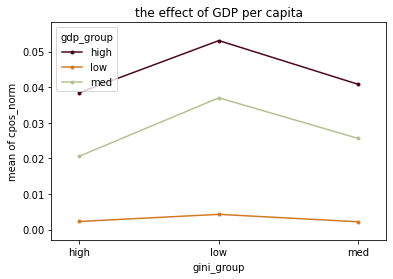

In [62]:
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
fig = interaction_plot(x=anova_df['gini_group'], trace=anova_df['gdp_group'], response=anova_df['cpos_norm'], 
    colors=['#4c061d','#d17a22', '#b4c292'])
plt.title('the effect of Gini index on mean of cumulative positive per capita')
plt.show()

This first graph above generally matches the ANOVA results: the purple and green lines are almost perfectly parallel, which suggest that there is no interaction between GDP per capita and Gini index. When Gini level is constant, change in GDP per Capita also does signficantly change the mean of cumulative positive cases per capita, thus proving the significant effect of GDP per capita found in ANOVA. 


However, the graph also shows that within the same Gini index level, the higher GDP per capita of a country, the higher the cumulative positive cases per capita, which is rather surprising. Moreover, despite the lack of interaction effect, Gini index seem to not matter when GDP per capita level is low. Both findings are worth analyzing in the discussion.

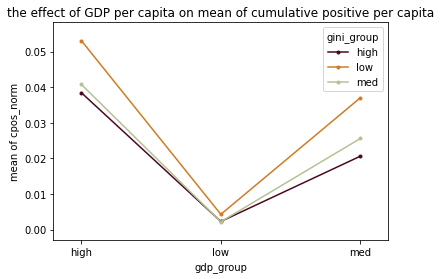

In [64]:
fig2 = interaction_plot(x=anova_df['gdp_group'], trace=anova_df['gini_group'], response=anova_df['cpos_norm'], 
    colors=['#4c061d','#d17a22', '#b4c292'])
plt.title('the effect of GDP per capita on mean of cumulative positive per capita')
plt.show()

This second graph visualizes the combination of ANOVA findings and effect size calculations of Gini Index––that is, although it has a significant effect on Cumulative positives per capita, such effect is rather small. Here on this graph, it is clear that within the same GDP per capita level, the higher the Gini level, the lower the value. However, the differences are significantly lower than those on the previous graph, especially the difference of value means between high and medium Gini indexes (and, again, especially at GDP per capita level = low, where there seem to be little to no difference). This finding is also worth discussing. To do so, we decide to first perform a Tukey HSD Test.

### Evaluation of Significance: Tukey HSD Tests 

Since the two-way ANOVA test could only tell us GDP per capita and Gini index are significant, but __not also how exactly different levels (high/med/low) of GDP per capita and Gini index affect cumulative positive rate per capita__, we decide to perform two post-hoc tests, one for each indepedent variable. And the tests are a Tukey Honestly-Significant-Difference (Tukey HSD) Tests.

The first Tukey HSD Test, for __GDP per capita__:

In [51]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# perform multiple pairwise comparison (Tukey HSD) for GDP per cap
m_comp_gdp = pairwise_tukeyhsd(endog=anova_df['cpos_norm'], groups=anova_df['gdp_group'], alpha=0.05)
m_comp_gdp.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
high,low,-0.0447,0.001,-0.056,-0.0335,True
high,med,-0.0203,0.001,-0.0317,-0.009,True
low,med,0.0244,0.001,0.0131,0.0356,True


This first Tukey HSD test returns a table that compares different pairs of GDP per capita levels (high vs. low, high vs. med, and low vs. med), and lists out each pair's mean difference (meandiff), p-value of the difference (p-adj) and the lower and upper bounds of the confidence intervals at 95% of mean difference (lower, upper). Also, it shows whether the null hypothesis that there is no sigfinicant difference between each pair's values should be rejected (reject). 

P.S. We continue to adopt a significance level of 0.05. But thanks to the function's convenient "reject" column, there is no need to manually compare 0.05 to p-adj.

From this table, we can infer that there are significant differences between the means of:
1. high and low GDP per capita
2. high and medium GDP per capita
3. low and medium GDP per capita

Also, among the three significant differences, the mean difference between high and low GDP is the highest (|-0.0447|).

The second Tukey HSD Test, for __Gini index__:

In [52]:
m_comp_gini = pairwise_tukeyhsd(endog=anova_df['cpos_norm'], groups=anova_df['gini_group'], alpha=0.05)
m_comp_gini.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
high,low,0.0245,0.001,0.0111,0.0379,True
high,med,0.0086,0.3082,-0.0053,0.0225,False
low,med,-0.0159,0.0178,-0.0295,-0.0023,True


Similar to the Tukey HSD Test for GDP per capita, the same Test for Gini index also returns a table with the same attributes. From this table, we can infer that there are significant differences between the means of:
1. high and low Gini index
2. low and medium Gini index

There is not a significant difference between the means of:
1. high and medium Gini index

This helps explain the proximity between the purple and green lines on the second graph.

Also, between the two significant differences, the mean difference between high and low Gini index is the highest (0.0245).

### ANOVA and Tukey HSD Results Summary

Through a two-way ANOVA test, we found that __both a country's GDP per capita and Gini Index cause significant difference__ on that country's cumulative positive cases per capita. Speficically, the significant effect by GDP per capita is __relatively stronger__ (F(2,127) = 33.87, p<0.05, η^2=34.8%), while the significant effect by Gini Index is __relatively weaker__ (F(2,127) = 3.16, p<0.05, η^2=4.7%). __We did not find a significant interaction effect__ between GDP per capita and Gini Index (F(4,127) = 0.45, p>0.05).


Through a Tukey HSD test, we also found that all pairwise comparisons of different levels of __GDP per capita__  result in significant mean differences of a country's cumulative positive cases per capita, specifically the __high vs. medium__ (meandiff=-0.0447), __high vs. low__ (meandiff=-0.0203), and __low vs. medium__ (meandiff=0.0244) GDP per capita pairs. For the __Gini index__ levels, only the __high vs. low__ (meanfidd=0.0245) and __low vs. medium__ (0.0159) pairs yield significant mean value differences; the __high vs. medium__ (meandiff=0.0086) pair __yields no significant mean value difference__.

Within the same Gini index level (and true to every Gini index level), the __higher the GDP per capita level__, the __higher the country's cumulative positive cases per capita__. Within the same GDP per capita level (and true to all but GDP = low level), the __higher the country's Gini index level__, the __lower the cumulative positive cases per capita__.

## Discussion/Interpretation of ANOVA and Tukey HSD Tests Results

The results come out as a surprise for us. We originally hypothesized that countries with higher GDP per capita (i.e. better economy and personal wealth) would yiled lower Covid positive cases per capita, because we assumed that  
1. people from those countries would share higher affordability of masks, sanitizers and other Covid essentials,
2. those countries usually provide better healthcare.
We also hypothesized that a combination of lower Gini Index (i.e. higher equality in terms of wealth distribution) and higher GDP per capita would have lower Covid positive cases per capita, assuming that 
1. this combination would mean fewer groups in poverty,
2. high Gini index alone (without medium or high GDP per capita) would probably yield higher numbers per capita due to "equal" lack of resources. 

However, the tests show just the opposite. 

First, within the same Gini level, the higher the level of GDP per capita, the higher the number of positive cases per capita. We believe that there are several factors that could possibly explain this significant effect:
1. many countries with high GDP per capita (e.g. the U.S. and Western European countries) are also the ones that run the most Covid tests and do so most frequently; this would lead to higher sample sizes per capita, which would in turn result in higher per capita positive cases.
2. many of those countries are also well-developed and have shrinking population age pyramids (i.e. has a higher percentage of elderly population; e.g. Japan). Since its common knowledge now that Covid-positive elderlies are more susceptible of developing (severe) symptoms, the percentage of those countries' Covid-positive population who feel and report symptons would naturally be higher. In other words, in low GDP per capita countries that has less % of elderly population, there might be a higher % of asymptomatic positive cases that are never reported or tested. For our next phase, we would further explore this idea by performing statistical tests on death rates per capita vs. GDP per capita.

Second, within the same GDP per capita level, the higher the level of Gini index (i.e. more unequal wealth distribution), the lower the number of positive cases per capita. This main effect can also be explained by the factors above, as most countries on the bottom-third Gini index level also have low GDP per capita. This significant effect, however, is relatively weak, as indicated by both its small effect size (4.7%) and p-value (0.046). Also, it is important to note that Gini Index would only have a significant effect with the significance level = 0.05. If we were to set the level to the more conservative 0.01, from 0.046>0.01 we would have concluded that this main effect is not significant. Therefore between the two significant factors, GDP per capita––not Gini index––is the dominant factor that influences cumulative positive cases per capita.

Third, shown by ANOVA, the fact that there is no significant interaction between GDP per capita and Gini index suggests that the strength of GDP per capita's effect does not depend on the state (level) of Gini index, and vice versa. However, from the two graphs in the Visual Representation section above, we could infer that when GDP per capita is low, the change in Gini index levels yields little difference in value means (and the values are very low). In other words, it seems that Gini index depends on the level of GDP per capita. We attribute this observation to the following possible reasons:
1. Among these low GDP per capita countries, the difference in Gini index does not change the fact that the governments provide fewer Covid tests so that fewer positive cases are documented.
2. The sample sizes for low GDP per capita countries that also has low or medium Gini index is low (i.e. most have high Gini index) and may have sampling errors.
3. The main effect of Gini index is inherently weak and debatable. 



Finally, the Tukey HSD test reveals an interesting finding that their is no significant value mean difference between high and medium Gini levels; the real significant difference occurs between high/medium vs. low. We are yet able to find a plausible explanation for this finding.

## Second Factorial Anova Test: Gini

In [35]:
#model1 = ols('cdec_norm ~ C(gdp_group) + C(gini_group) + C(gdp_group):C(gini_group)', data=anova_df).fit()
#sm.stats.anova_lm(model1, typ=2)

,sum_sq,df,F,PR(>F)
C(gdp_group),1.362762e-05,2.0,28.882553,4.583204e-11
C(gini_group),5.766377e-07,2.0,1.222134,2.980418e-01
C(gdp_group):C(gini_group),4.229644e-07,4.0,0.448218,7.735282e-01
Residual,2.996112e-05,127.0,NaN,NaN


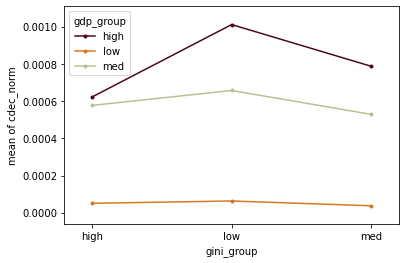

In [39]:
#fig = interaction_plot(x=anova_df['gini_group'], trace=anova_df['gdp_group'], response=anova_df['cdec_norm'], 
   # colors=['#4c061d','#d17a22', '#b4c292'])
#plt.show()